# PyTorch Practice
## Setup
First make sure working environment is correct.

In [40]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])

pytorch


Import necessary packages for building a CNN for image classifier and displaying images.

In [41]:
# Default packages
import numpy as np
import matplotlib.pyplot as plt

# Torch and torchvision packages
import torch
import torchvision
import torchvision.transforms as transforms

# Neural net and optimizer packages
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Load the training data.

In [42]:
# Transforming image range of [0,1] to [-1,1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

# Loading dataset for training
trainset = torchvision.datasets.CIFAR10(root='/home/liam/Projects/pytorch', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Loading dataset for testing
testset = torchvision.datasets.CIFAR10(root='/home/liam/Projects/pytorch', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Now let's look at some of the training images and their labels

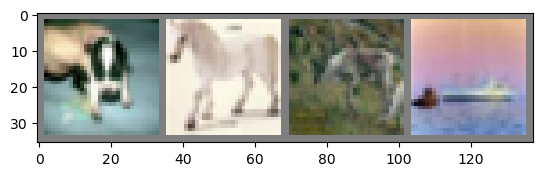

dog   horse deer  ship 


In [43]:
# function to display images
def imshow(img):
    img = img / 2 + 0.5     # convert back to [0,1] from [-1,1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Create a neural network to take in three-channel images.

In [47]:
# Defining GPU device to use
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# Redefining neural net
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 5) # 5x5 kernel, 3-input layer -> 10-hidden layer
        self.pool = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(10, 16, 5) # 5x5 kernel, 10-hidden layer -> 16-hidden layer
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # linear transformation to 120 element array
        self.fc2 = nn.Linear(120, 84) # linear transformation 120 -> 84 element array
        self.fc3 = nn.Linear(84, 10) # linear transformation 84 -> 10 element output array

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x)) # ReLu activation function
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

cuda:0


Net(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Now define a Loss function and optimizer.

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Train the neural network by looping over a data iterator and feeding the inputs to the network in order to optimize outputs.

In [49]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs).to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.151
[1,  4000] loss: 1.795
[1,  6000] loss: 1.621
[1,  8000] loss: 1.521
[1, 10000] loss: 1.467
[1, 12000] loss: 1.433
[2,  2000] loss: 1.354
[2,  4000] loss: 1.313
[2,  6000] loss: 1.287
[2,  8000] loss: 1.286
[2, 10000] loss: 1.249
[2, 12000] loss: 1.213
Finished Training


Now save the model.

In [50]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Test the trained model on the test data. Look at a few images with the corresponding ground truths.

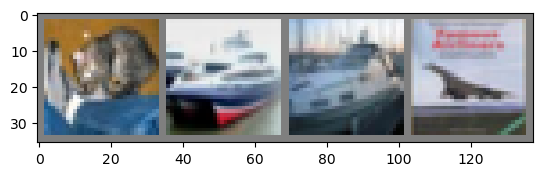

GroundTruth:  cat   ship  ship  plane


In [51]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Now load the saved model, which doesn't have to be done since it is already stored in this ipynb but this is how it should be done.

In [52]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Test the previous images with the model and see if the predictions match the ground truth.

In [53]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   plane ship  plane


There are clearly some errors in the prediction of the network, so check the network peformance across the whole dataset.

In [54]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 56 %


Next analyze the accuracies for each class of data.

In [55]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 70.4 %
Accuracy for class: car   is 62.2 %
Accuracy for class: bird  is 51.2 %
Accuracy for class: cat   is 58.7 %
Accuracy for class: deer  is 27.5 %
Accuracy for class: dog   is 46.5 %
Accuracy for class: frog  is 65.8 %
Accuracy for class: horse is 50.1 %
Accuracy for class: ship  is 65.4 %
Accuracy for class: truck is 62.8 %
